In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('dataset/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
card_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [3]:
# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [5]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                       test_size=0.3, random_state=0,
                                                       stratify=y_target)
    return X_train,X_test,y_train,y_test
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [14]:
# 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, roc_auc_score

def get_clf_eval(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬\n',confusion)    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, auc))

In [15]:
# 로지스틱 리그레션을 적용한 모델 학습 및 평가
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,lr_pred, lr_pred_proba)

오차 행렬
 [[85283    12]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8788, 재현율: 0.5878,    F1: 0.7045, AUC:0.9573


In [18]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 
# 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, 
                         tgt_train=None, tgt_test=None):
    model.fit(ftr_train,tgt_train)
    pred=model.predict(ftr_test)
    pred_proba=model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [20]:
# 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로
# 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, 
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

오차 행렬
 [[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


### 데이터 분포도 변환 후 모델 학습/예측/평가

<AxesSubplot:xlabel='Amount', ylabel='Density'>

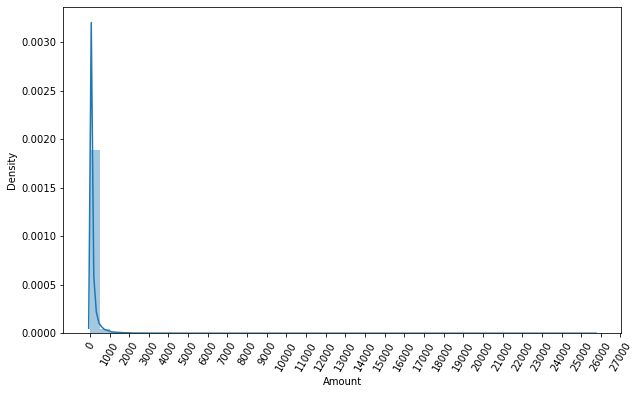

In [21]:
import seaborn as sns

plt.figure(figsize=(10,6))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [22]:
card_df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [25]:
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 
# 로직으로 수정.
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n) # Amount_Scaled 칼럼값으로 amount_n 데이터를 공통적으로 집어넣는다.
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [26]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) # n_estimator 반복 수행 트리 개수
# num_leaves 하나의 트리가 가질 수 있는 최대 리프 개수
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


In [ ]:
# 넘파이의 log1p( )를 이용하여 Amount를 로그 변환

In [ ]:
# Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행. 